## CCD and TED

In [50]:
import gzip
import json
import os
import sys
from os import PathLike, path
from paramiko.client import SSHClient, AutoAddPolicy
from typing import List, Tuple, TypeAlias, Generator, Iterable, TypedDict
from huggingface_hub import list_datasets
from datasets import load_dataset, load_dataset_builder
from transformers import AutoTokenizer
from transformers.tokenization_utils_base import PreTrainedTokenizerBase
from functools import wraps, reduce
import shutil
from util import load_jsonl, get_samples, get_samples_greedy, gpto_get_samples, gpto_get_samples_greedy, tokenize_code, get_edit_distance_distribution_star, calculate_ratio, openai_get_samples_instruct, openai_get_samples_greedy_instruct


class GenerationConf(TypedDict):
    identifier: str
    tokenizer: str
    method: str
    greedy_path: str
    multiple_path: str

class ExperimentalResults(TypedDict):
    conf: GenerationConf
    bugs: List[None | str]
    skipped_list: List[None | bool]
    dists_list: List[None | List[int]]
    cdd_peak_list: List[None | float]
    cdd_leaked_list: List[None | bool]
    ted_filtered_dists_list: List[None | List[int]]
    ted_filtered_peak_list: List[None | float]
    ted_filtered_leaked_list: List[None | bool]

Tokens: TypeAlias = List[int]


alpha: float = 0.05
xi: float = 0.01
tau: int = 2
max_length: int = 100

def process_item(task: str, greedy_sample: str, multiple_samples: List[str], tokenizer: PreTrainedTokenizerBase) -> dict:
    # Tokenize
    tokenized_multiple_samples: List[Tokens] = [
        tokenize_code(s, tokenizer, max_length) for s in multiple_samples
    ]
    tokenized_greedy_sample: Tokens = tokenize_code(greedy_sample, tokenizer, max_length)
    # Calculate EDD
    dists, ml = get_edit_distance_distribution_star(tokenized_multiple_samples, tokenized_greedy_sample)

    # CDD
    cdd_peak = calculate_ratio(dists, alpha * ml)
    cdd_leaked = cdd_peak > xi

    # TED
    ted_sample_is_filtered = [False for _ in multiple_samples]
    ted_used = set()
    for i, sample, d in zip(range(len(tokenized_multiple_samples)), tokenized_multiple_samples, dists):
        if tuple(sample) in ted_used: ted_sample_is_filtered[i] = True  # Remove duplicates
        ted_used.add(tuple(sample))
        if not d > tau: ted_sample_is_filtered[i] = True  # Remove peakedness
    ted_filtered_dists = [d for d, f in zip(dists, ted_sample_is_filtered) if not f]
    ted_filtered_peak = calculate_ratio(ted_filtered_dists, alpha * ml)
    ted_filtered_leaked = ted_filtered_peak > xi
    return {
        "identifier": task,
        "dists": dists,
        "max_length": ml,
        "cdd_peak": cdd_peak,
        "cdd_leaked": cdd_leaked,
        "ted_sample_is_filtered": ted_sample_is_filtered,
        "ted_filtered_dists": ted_filtered_dists,
        "ted_filtered_peak": ted_filtered_peak,
        "ted_filtered_leaked": ted_filtered_leaked,
    }

def run_experiment(conf: GenerationConf, **kvargs) -> ExperimentalResults:
    tokenizer = AutoTokenizer.from_pretrained(conf["tokenizer"])
    greedy_path = conf["greedy_path"]
    multiple_path = conf["multiple_path"]
    # Load the multiple generation data
    if multiple_path.endswith(".gz"):
        data = load_jsonl(multiple_path, gzip.open)
    else:
        data = load_jsonl(multiple_path)
    multiple_samples_taskset = data

    # Load the greedy generation data
    if greedy_path.endswith(".gz"):
        data = load_jsonl(greedy_path, gzip.open)
    else:
        data = load_jsonl(greedy_path)
    greedy_samples_taskset = data
    
    # dataset speficic functions
    match conf["method"]:
        case "openai-instruct":
            samples_fun, greedy_sample_fun = openai_get_samples_instruct, openai_get_samples_greedy_instruct
        case "huggingface":
            samples_fun, greedy_sample_fun = get_samples, get_samples_greedy
        case _:
            raise ValueError(f"Unknown method: {conf['method']}")
    
    greedy_sample_set = set(e["identifier"] for e in greedy_samples_taskset)
    multiple_samples_set = set(e["identifier"] for e in multiple_samples_taskset)
    all_samples_in_tasksets = greedy_sample_set | multiple_samples_set
    common_samples = greedy_sample_set & multiple_samples_set

    # get greedy samples
    all_greedy_sample_taskset_map = {s["identifier"]: greedy_sample_fun(s) for s in greedy_samples_taskset}
    all_multiple_samples_taskset_map = {s["identifier"]: samples_fun(s) for s in multiple_samples_taskset}

    # Keep only common identifiers, preserve order
    greedy_sample_taskset_map = {k: v for k, v in all_greedy_sample_taskset_map.items() if k in common_samples}
    multiple_samples_taskset_map = {k: v for k, v in all_multiple_samples_taskset_map.items() if k in common_samples}

    task_identifiers: List[str] = list(greedy_sample_taskset_map.keys())
    
    experiment_results = []
    for i, task in enumerate(task_identifiers):
        res = {
            "identifier": task,
            "skipped": False,
            "dists": None,
            "cdd_peak": None,
            "cdd_leaked": None,
            "ted_filtered_dists": None,
            "ted_filtered_peak": None,
            "ted_filtered_leaked": None,
        }

        greedy_sample = greedy_sample_taskset_map[task]
        if not greedy_sample:
            experiment_results.append({
                **res,
                "skipped": "Invalid greedy sample"
            })
            continue
        multiple_samples = multiple_samples_taskset_map[task]
        if multiple_samples is None:
            experiment_results.append({
                **res,
                "skipped": "Invalid multiple samples"
            })
            continue
        multiple_samples = list(filter(None, multiple_samples))
        if len(multiple_samples) == 0:
            experiment_results.append({
                **res,
                "skipped": "No valid samples"
            })
            continue
        bug_experiment_results = process_item(task, greedy_sample, multiple_samples, tokenizer)
        experiment_results.append({
            **res,
            **bug_experiment_results
        })
    return {
        "conf": conf,        
        "bugs": experiment_results,
    }

conf_list: List[GenerationConf] = [
    # # GPT-4o
    # {
    #     "identifier": "Defect4J gpt-4o 2024-08-06",
    #     "greedy_path": "data/gpt-4o/defects4j/greedy/candidates_defects4j_instruct_openai-chatcompletion_model_name=gpt-4o-2024-08-06_temperature=0.0_n_samples=1.jsonl",
    #     "multiple_path": "data/gpt-4o/defects4j/multiple/candidates_defects4j_instruct_openai-chatcompletion_model_name=gpt-4o-2024-08-06_n_samples=10_temperature=1.0.jsonl",
    #     "method": "gpt-4o",
    #     "tokenizer": "Xenova/gpt-4o"
    # },
    # {
    #     "identifier": "GitBugJava gpt-4o 2024-08-06",
    #     "greedy_path": "data/gpt-4o/gitbug-java/greedy/candidates_gitbugjava_instruct_openai-chatcompletion_model_name=gpt-4o-2024-08-06_temperature=0.0_n_samples=1.jsonl",
    #     "multiple_path": "data/gpt-4o/gitbug-java/multiple/candidates_gitbugjava_instruct_openai-chatcompletion_model_name=gpt-4o-2024-08-06_n_samples=10_temperature=1.0.jsonl",
    #     "method": "gpt-4o",
    #     "tokenizer": "Xenova/gpt-4o"
    # },
    # # GitBugJava starcoder
    # {
    #     "identifier": "GitBugJava starcoder",
    #     "greedy_path": "data/starcoder/gitbug-java/greedy/candidates_GitBugJava_fill-in-the-middle_starcoder_temperature=0.0_n_samples=1_num_return_sequences=1.jsonl",
    #     "multiple_path": "data/starcoder/gitbug-java/multiple/candidates_GitBugJava_fill-in-the-middle_starcoder_generation_strategy=beam_search_num_beams=10_num_return_sequences=10.jsonl",
    #     "method": "starcoder",
    #     "tokenizer": "bigcode/starcoder"
    # },
    # {
    #     "identifier": "GitBugJava starcoderbase-1b",
    #     "greedy_path": "data/starcoderbase-1b/gitbug-java/greedy/candidates_GitBugJava_fill-in-the-middle_starcoderbase-1b_temperature=0.0_n_samples=1_num_return_sequences=1.jsonl",
    #     "multiple_path": "data/starcoderbase-1b/gitbug-java/multiple/candidates_GitBugJava_fill-in-the-middle_starcoderbase-1b_generation_strategy=beam_search_num_beams=10_num_return_sequences=10.jsonl",
    #     "method": "starcoder",
    #     "tokenizer": "bigcode/starcoderbase-1b"
    # },
    # {
    #     "identifier": "GitBugJava starcoderplus",
    #     "greedy_path": "data/starcoderplus/gitbug-java/greedy/candidates_GitBugJava_fill-in-the-middle_starcoderplus_temperature=0.0_n_samples=1_num_return_sequences=1.jsonl",
    #     "multiple_path": "data/starcoderplus/gitbug-java/multiple/candidates_GitBugJava_fill-in-the-middle_starcoderplus_generation_strategy=beam_search_num_beams=10_num_return_sequences=10.jsonl",
    #     "method": "starcoder",
    #     "tokenizer": "bigcode/starcoderplus"
    # },
    # {
    #     "identifier": "GitBugJava starcoder t=0.8",
    #     "greedy_path": "data/starcoder/gitbug-java/greedy/candidates_GitBugJava_fill-in-the-middle_starcoder_temperature=0.0_n_samples=1_num_return_sequences=1.jsonl",
    #     "multiple_path": "data/starcoder/gitbug-java/multiple/candidates_GitBugJava_fill-in-the-middle_starcoder_temperature=0.8_generation_strategy=beam_search_num_beams=10_num_return_sequences=10.jsonl",
    #     "method": "starcoder",
    #     "tokenizer": "bigcode/starcoder"
    # },
    # # HumanEvalJava starcoder
    # {
    #     "identifier": "HumanEvalJava starcoder",
    #     "greedy_path": "data/starcoder/humaneval-java/greedy/candidates_HumanEvalJava_fill-in-the-middle_starcoder_temperature=0.0_n_samples=1_num_return_sequences=1.jsonl",
    #     "multiple_path": "data/starcoder/humaneval-java/multiple/candidates_HumanEvalJava_fill-in-the-middle_starcoder_generation_strategy=beam_search_num_beams=10_num_return_sequences=10.jsonl",
    #     "method": "starcoder",
    #     "tokenizer": "bigcode/starcoder"
    # },
    # {
    #     "identifier": "HumanEvalJava starcoderbase-1b",
    #     "greedy_path": "data/starcoderbase-1b/humaneval-java/greedy/candidates_HumanEvalJava_fill-in-the-middle_starcoderbase-1b_temperature=0.0_n_samples=1_num_return_sequences=1.jsonl",
    #     "multiple_path": "data/starcoderbase-1b/humaneval-java/multiple/candidates_HumanEvalJava_fill-in-the-middle_starcoderbase-1b_generation_strategy=beam_search_num_beams=10_num_return_sequences=10.jsonl",
    #     "method": "starcoder",
    #     "tokenizer": "bigcode/starcoderbase-1b"
    # },
    # {
    #     "identifier": "HumanEvalJava starcoderplus",
    #     "greedy_path": "data/starcoderplus/humaneval-java/greedy/candidates_HumanEvalJava_fill-in-the-middle_starcoderplus_temperature=0.0_n_samples=1_num_return_sequences=1.jsonl",
    #     "multiple_path": "data/starcoderplus/humaneval-java/multiple/candidates_HumanEvalJava_fill-in-the-middle_starcoderplus_generation_strategy=beam_search_num_beams=10_num_return_sequences=10.jsonl",
    #     "method": "starcoder",
    #     "tokenizer": "bigcode/starcoderplus"
    # },
    # {
    #     "identifier": "HumanEvalJava starcoder t=0.8",
    #     "greedy_path": "data/starcoder/humaneval-java/greedy/candidates_HumanEvalJava_fill-in-the-middle_starcoder_temperature=0.0_n_samples=1_num_return_sequences=1.jsonl",
    #     "multiple_path": "data/starcoder/humaneval-java/multiple/candidates_HumanEvalJava_fill-in-the-middle_starcoder_temperature=0.8_generation_strategy=beam_search_num_beams=10_num_return_sequences=10.jsonl",
    #     "method": "starcoder",
    #     "tokenizer": "bigcode/starcoder"
    # },
    # # Defects4J starcoder
    # {
    #     "identifier": "Defects4J starcoder",
    #     "greedy_path": "data/starcoder/defects4j/greedy/candidates_Defects4J_fill-in-the-middle_starcoder_temperature=0.0_n_samples=1_num_return_sequences=1.jsonl",
    #     "multiple_path": "data/starcoder/defects4j/multiple/candidates_Defects4J_fill-in-the-middle_starcoder_generation_strategy=beam_search_num_beams=10_num_return_sequences=10.jsonl",
    #     "method": "starcoder",
    #     "tokenizer": "bigcode/starcoder"
    # },
    # {
    #     "identifier": "Defects4J starcoderbase-1b",
    #     "greedy_path": "data/starcoderbase-1b/defects4j/greedy/candidates_Defects4J_fill-in-the-middle_starcoderbase-1b_temperature=0.0_n_samples=1_num_return_sequences=1.jsonl",
    #     "multiple_path": "data/starcoderbase-1b/defects4j/multiple/candidates_Defects4J_fill-in-the-middle_starcoderbase-1b_generation_strategy=beam_search_num_beams=10_num_return_sequences=10.jsonl",
    #     "method": "starcoder",
    #     "tokenizer": "bigcode/starcoderbase-1b"
    # },
    # {
    #     "identifier": "Defects4J starcoderplus",
    #     "greedy_path": "data/starcoderplus/defects4j/greedy/candidates_Defects4J_fill-in-the-middle_starcoderplus_temperature=0.0_n_samples=1_num_return_sequences=1.jsonl",
    #     "multiple_path": "data/starcoderplus/defects4j/multiple/candidates_Defects4J_fill-in-the-middle_starcoderplus_generation_strategy=beam_search_num_beams=10_num_return_sequences=10.jsonl",
    #     "method": "starcoder",
    #     "tokenizer": "bigcode/starcoderplus"
    # },
    # {
    #     "identifier": "Defects4J starcoder t=0.8",
    #     "greedy_path": "data/starcoder/defects4j/greedy/candidates_Defects4J_fill-in-the-middle_starcoder_temperature=0.0_n_samples=1_num_return_sequences=1.jsonl",
    #     "multiple_path": "data/starcoder/defects4j/multiple/candidates_Defects4J_fill-in-the-middle_starcoder_temperature=0.8_generation_strategy=beam_search_num_beams=10_num_return_sequences=10.jsonl",
    #     "method": "starcoder",
    #     "tokenizer": "bigcode/starcoder"
    # },
    # # TODO: Add the codellama-7b models
    # # Defects4J codellama-7b
    # {
    #     "identifier": "Defects4J codellama-7b",
    #     "greedy_path": "data/codellama-7b/defects4j/greedy/candidates_Defects4J_fill-in-the-middle_codellama-7b_temperature=0.0_n_samples=1_num_return_sequences=1.jsonl",
    #     "multiple_path": "data/codellama-7b/defects4j/multiple/candidates_Defects4J_fill-in-the-middle_codellama-7b_generation_strategy=beam_search_num_beams=10_num_return_sequences=10.jsonl",
    #     "method": "starcoder",
    #     "tokenizer": "codellama/CodeLlama-7b-hf"
    # },
    # # HumanEvalJava codellama-7b
    # {
    #     "identifier": "HumanEvalJava codellama-7b",
    #     "greedy_path": "data/codellama-7b/humaneval-java/greedy/candidates_HumanEvalJava_fill-in-the-middle_codellama-7b_temperature=0.0_n_samples=1_num_return_sequences=1.jsonl",
    #     "multiple_path": "data/codellama-7b/humaneval-java/multiple/candidates_HumanEvalJava_fill-in-the-middle_codellama-7b_generation_strategy=beam_search_num_beams=10_num_return_sequences=10.jsonl",
    #     "method": "starcoder",
    #     "tokenizer": "codellama/CodeLlama-7b-hf"
    # },
    # # GitBugJava codellama-7b
    # {
    #     "identifier": "GitBugJava codellama-7b",
    #     "greedy_path": "data/codellama-7b/gitbug-java/greedy/candidates_GitBugJava_fill-in-the-middle_codellama-7b_temperature=0.0_n_samples=1_num_return_sequences=1.jsonl",
    #     "multiple_path": "data/codellama-7b/gitbug-java/multiple/candidates_GitBugJava_fill-in-the-middle_codellama-7b_generation_strategy=beam_search_num_beams=10_num_return_sequences=10.jsonl",
    #     "method": "starcoder",
    #     "tokenizer": "codellama/CodeLlama-7b-hf"
    # },
    # # HumanEvalJava codellama-7b sigonly t=0.8,
    # {
    #     "identifier": "HumanEvalJava codellama-7b sigonly t=0.8",
    #     "greedy_path": "data/codellama-7b/humaneval-java/greedy/candidates_HumanEvalJava_sigonly_codellama-7b_temperature=0.0_n_samples=1_num_return_sequences=1.jsonl",
    #     "multiple_path": "data/codellama-7b/humaneval-java/multiple/candidates_HumanEvalJava_sigonly_codellama-7b_temperature=0.8_generation_strategy=beam_search_num_beams=10_num_return_sequences=10.jsonl",
    #     "method": "codellama",
    #     "tokenizer": "codellama/CodeLlama-7b-hf",
    # },
    # # Defects4J codellama-7b sigonly t=0.8,
    # {
    #     "identifier": "Defects4J codellama-7b sigonly t=0.8",
    #     "greedy_path": "data/codellama-7b/defects4j/greedy/candidates_Defects4J_sigonly_codellama-7b_temperature=0.0_n_samples=1_num_return_sequences=1.jsonl",
    #     "multiple_path": "data/codellama-7b/defects4j/multiple/candidates_Defects4J_sigonly_codellama-7b_temperature=0.8_generation_strategy=beam_search_num_beams=10_num_return_sequences=10.jsonl",
    #     "method": "codellama",
    #     "tokenizer": "codellama/CodeLlama-7b-hf",
    # },
    # # GitBugJava codellama-7b sigonly t=0.8,
    # {
    #     "identifier": "GitBugJava codellama-7b sigonly t=0.8",
    #     "greedy_path": "data/codellama-7b/gitbug-java/greedy/candidates_GitBugJava_sigonly_codellama-7b_temperature=0.0_n_samples=1_num_return_sequences=1.jsonl",
    #     "multiple_path": "data/codellama-7b/gitbug-java/multiple/candidates_GitBugJava_sigonly_codellama-7b_temperature=0.8_generation_strategy=beam_search_num_beams=10_num_return_sequences=10.jsonl",
    #     "method": "codellama",
    #     "tokenizer": "codellama/CodeLlama-7b-hf",
    # },

    # ====================================================
    # Berzelius data
    # ====================================================
    # {
    #     "identifier": "HumanEvalJava gpt-4o-mini sigonly-instruct",
    #     "greedy_path": "data/humaneval-java/gpt-4o-mini/greedy/candidates_HumanEvalJava_sigonly-instruct_openai-chatcompletion_model_name=gpt-4o-mini_generation_strategy=beam_search_num_return_sequences=1.jsonl",
    #     "multiple_path": "data/humaneval-java/gpt-4o-mini/multiple/candidates_HumanEvalJava_sigonly-instruct_openai-chatcompletion_model_name=gpt-4o-mini_max_length=4096_temperature=0.8_generation_strategy=sampling_num_return_sequences=50.jsonl",
    #     "method": "openai-instruct",
    #     "tokenizer": "Xenova/gpt-4o",
    # },
    # {
    #     "identifier": "GitBugJava gpt-4o-mini sigonly-instruct",
    #     "greedy_path": "data/gitbug-java/gpt-4o-mini/greedy/candidates_GitBugJava_sigonly-instruct_openai-chatcompletion_model_name=gpt-4o-mini_generation_strategy=beam_search_num_return_sequences=1.jsonl",
    #     "multiple_path": "data/gitbug-java/gpt-4o-mini/multiple/candidates_GitBugJava_sigonly-instruct_openai-chatcompletion_model_name=gpt-4o-mini_max_length=4096_temperature=0.8_generation_strategy=sampling_num_return_sequences=50.jsonl",
    #     "method": "openai-instruct",
    #     "tokenizer": "Xenova/gpt-4o",
    # },
    # {
    #     "identifier": "Defects4J gpt-4o-mini sigonly-instruct",
    #     "greedy_path": "data/defects4j/gpt-4o-mini/greedy/candidates_Defects4J_sigonly-instruct_openai-chatcompletion_model_name=gpt-4o-mini_generation_strategy=beam_search_num_return_sequences=1.jsonl",
    #     "multiple_path": "data/defects4j/gpt-4o-mini/multiple/candidates_Defects4J_sigonly-instruct_openai-chatcompletion_model_name=gpt-4o-mini_max_length=4096_temperature=0.8_generation_strategy=sampling_num_return_sequences=50.jsonl",
    #     "method": "openai-instruct",
    #     "tokenizer": "Xenova/gpt-4o",
    # },
    {
        "identifier": "humaneval-java",
        "greedy_path": "data/humaneval-java/meta-llama/CodeLlama-7b-Instruct-hf/greedy/candidates_HumanEvalJava_sigonly-instruct_codellama-instruct_model_name=meta-llama:CodeLlama-7b-Instruct-hf_max_length=4096_generation_strategy=beam_search_num_return_sequences=1.jsonl",
        "multiple_path": "data/humaneval-java/candidates_HumanEvalJava_sigonly-instruct_codellama-instruct_model_name=meta-llama:CodeLlama-7b-Instruct-hf_max_length=4096_temperature=0.05_generation_strategy=sampling_num_return_sequences=10_all.jsonl",
        "method": "huggingface",
        "tokenizer": "meta-llama/CodeLlama-7b-hf",
    },
    {
        "identifier": "gitbug-java",
        "greedy_path": "data/gitbug-java/meta-llama/CodeLlama-7b-Instruct-hf/greedy/candidates_GitBugJava_sigonly-instruct_codellama-instruct_model_name=meta-llama:CodeLlama-7b-Instruct-hf_max_length=4096_generation_strategy=beam_search_num_return_sequences=1.jsonl",
        "multiple_path": "data/gitbug-java/candidates_GitBugJava_sigonly-instruct_codellama-instruct_model_name=meta-llama:CodeLlama-7b-Instruct-hf_max_length=4096_temperature=0.05_generation_strategy=sampling_num_return_sequences=10_all.jsonl",
        "method": "huggingface",
        "tokenizer": "meta-llama/CodeLlama-7b-hf",
    },
    {
        "identifier": "defects4j",
        "greedy_path": "data/defects4j/meta-llama/CodeLlama-7b-Instruct-hf/greedy/candidates_Defects4J_sigonly-instruct_codellama-instruct_model_name=meta-llama:CodeLlama-7b-Instruct-hf_max_length=4096_generation_strategy=beam_search_num_return_sequences=1.jsonl",
        "multiple_path": "data/defects4j/candidates_Defects4J_sigonly-instruct_codellama-instruct_model_name=meta-llama:CodeLlama-7b-Instruct-hf_max_length=4096_temperature=0.05_generation_strategy=sampling_num_return_sequences=10_all.jsonl",
        "method": "huggingface",
        "tokenizer": "meta-llama/CodeLlama-7b-hf",
    },
]


experimental_results = list(map(run_experiment, conf_list))
bugs_list = []
skipped_list = []
dists_list = []
peaks_list = []
cdd_leaks_list = []
# invalid_multiple_candidates_list = []
# invalid_greedy_candidates_list = []
for res in experimental_results:
    # Add results to the lists
    bugs = res["bugs"]
    bugs_list.append([e["identifier"] for e in bugs])
    skipped_list.append([e["skipped"] for e in bugs])
    dists_list.append([e["dists"] for e in bugs])  # Add benchmark dists to job dists
    peaks_list.append([e["cdd_peak"] for e in bugs])
    cdd_leaks_list.append([e["cdd_leaked"] for e in bugs])
    # invalid_multiple_candidates_list.append(InvalidMultipleSamples)
    # invalid_greedy_candidates_list.append(InvalidGreedySamples)



In [9]:
from collections import Counter

# Save results to .json file as {benchmark-bug_id: str -> [edit_distance_star: int]}

CDD_DATA_CACHE = "cdd-data-cache.json"

bug_cdd_data = {}
for conf, bench_dists in zip(conf_list, dists_list):
    # Read bugs
    bench_identifier = conf["identifier"]
    greedy_path = conf["greedy_path"]
    with open(greedy_path, "r") as file:
        lines = file.readlines()
    data = map(json.loads, lines)

    for row, bug_dists in zip(data, bench_dists):
        bug_identifier = f"{bench_identifier}-{row['identifier']}"
        bug_cdd_data[bug_identifier] = bug_dists

with open(CDD_DATA_CACHE, "w") as f:
    f.write(json.dumps(bug_cdd_data))

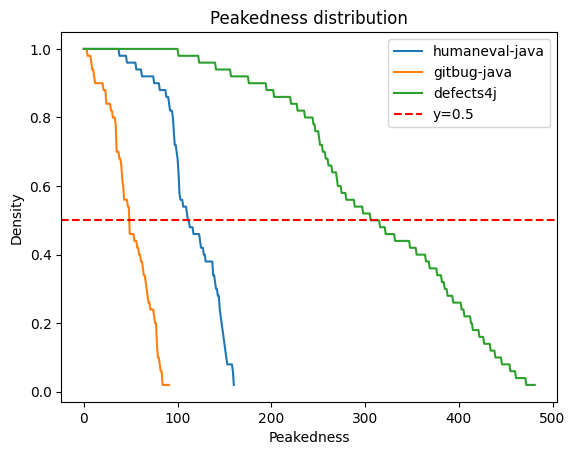

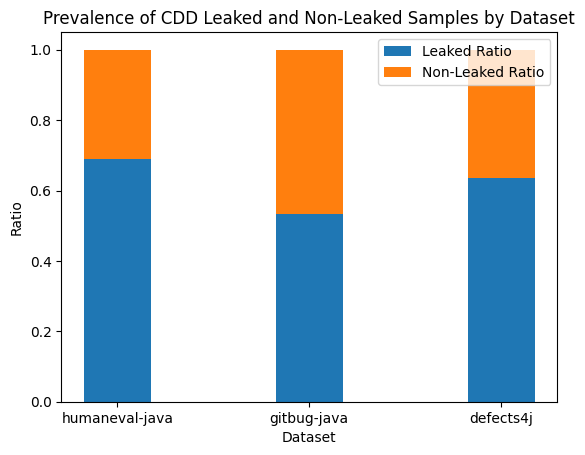

In [11]:
# Plot peakedness

import matplotlib.pyplot as plt
from collections import Counter
import numpy as np
import os

FIG_FOLDER = "paper_figures"
os.makedirs(FIG_FOLDER, exist_ok=True)

xi = 0.5

for res in experimental_results:
    cdd_peak_list = [e["cdd_peak"] for e in res["bugs"]]
    cdd_peak_list = list(filter(None, cdd_peak_list))
    sorted_peaks = sorted(cdd_peak_list, reverse=True)
    plt.plot(sorted_peaks, label=res["conf"]["identifier"])

plt.axhline(y=xi, color='r', linestyle='--', label=f'y={xi}')
plt.xlabel("Peakedness")
plt.ylabel("Density")
plt.title("Peakedness distribution")
plt.legend()

plt.savefig(f"{FIG_FOLDER}/peakedness-distribution.png")
plt.show()

# Plot CDD Leaked and Non-Leaked Ratios

identifiers = [e["identifier"] for e in conf_list]
index = np.arange(len(identifiers))  # The label locations

cdd_leaked_ratios = []
cdd_non_leaked_ratios = []

for res in experimental_results:
    cdd_peak_list = [e["cdd_peak"] for e in res["bugs"]]
    cdd_leaked_list_filtered = list(filter(None, cdd_peak_list))
    cdd_leaked_count = sum([e > xi for e in cdd_leaked_list_filtered])
    bug_count = len(cdd_leaked_list_filtered)
    cdd_leaked_ratio = cdd_leaked_count / bug_count
    cdd_non_leaked_ratio = 1 - cdd_leaked_ratio
    
    cdd_leaked_ratios.append(cdd_leaked_ratio)
    cdd_non_leaked_ratios.append(cdd_non_leaked_ratio)

fig, ax = plt.subplots()
bar_width = 0.35

p1 = ax.bar(index, cdd_leaked_ratios, bar_width, label='Leaked Ratio')
p2 = ax.bar(index, cdd_non_leaked_ratios, bar_width, bottom=cdd_leaked_ratios, label='Non-Leaked Ratio')

ax.set_xlabel('Dataset')
ax.set_ylabel('Ratio')
ax.set_title('Prevalence of CDD Leaked and Non-Leaked Samples by Dataset')
ax.set_xticks(index)
ax.set_xticklabels(identifiers)
ax.legend()

plt.savefig(f"{FIG_FOLDER}/cdd-leaked-ratio.png")
plt.show()



In [ ]:
from typing import List
import json
import matplotlib.pyplot as plt
import pandas as pd
from collections import Counter

benchmark_excludes = {
    "defects4j": [],
    "gitbugjava": [],
}

# Get evaluation files for each benchmark

def get_eval_path(benchmark: str) -> str:
    return f"repairbench/results/llama-3.3-70b-instruct/{benchmark}/evaluation_{benchmark}_instruct_openrouter.jsonl"

def get_eval_data(benchmark: str) -> List[dict]:
    with open(get_eval_path(benchmark), "r") as f:
        data = list(map(json.loads, f.readlines()))
    return data

benchmark_str_list = ["defects4j", "gitbugjava"]
# model_tokenizer = "meta-llama/Llama-3.3-70B-Instruct"
model_tokenizer = "meta-llama/Meta-Llama-3-8B"
tokenizer = AutoTokenizer.from_pretrained(model_tokenizer)
benchmark_bugs_stats_df = pd.DataFrame([], columns=["compile", "test", "ast_match", "exact_match"])
benchmark_cdd_filtered_bugs_stats_df = pd.DataFrame([], columns=["compile", "test", "ast_match", "exact_match"])
benchmark_samples_stats_df = pd.DataFrame([], columns=["compile", "test", "ast_match", "exact_match"])
benchmark_ted_filtered_samples_stats_df = pd.DataFrame([], columns=["compile", "test", "ast_match", "exact_match"])
for benchmark_str in benchmark_str_list:
    data = get_eval_data(benchmark_str)
    benchmark_samples_stats = Counter(compile=0, test=0, ast_match=0, exact_match=0)
    benchmark_ted_filtered_samples_stats = Counter(compile=0, test=0, ast_match=0, exact_match=0)
    benchmark_bug_stats = Counter(compile=0, test=0, ast_match=0, exact_match=0)
    benchmark_bug_cdd_filtered_stats = Counter(compile=0, test=0, ast_match=0, exact_match=0)
    for bug_data in data:
        # Benchmark bug data
        identifier = bug_data["identifier"]
        buggy_code = bug_data["buggy_code"]
        fixed_code = bug_data["fixed_code"]

        # Evaluation
        eval_data = bug_data["evaluation"]
        if eval_data is None:
            continue
        eval_data = filter(None, eval_data)
        eval_data = filter(lambda e: e["generation"] is not None, eval_data)
        eval_data = list(eval_data)
        if len(eval_data) == 0:
            continue  # For the wierd case `[None, None, ...]`

        multi_samples = [e["generation"] for e in eval_data]
        res = process_item(identifier, fixed_code, multi_samples, tokenizer)  # CDD & TED

        # Samples stats
        samples_stats = Counter(compile=0, test=0, ast_match=0, exact_match=0)
        ted_filtered_samples_stats = Counter(compile=0, test=0, ast_match=0, exact_match=0)
        # print("benchmark", benchmark_str)
        # print("identifier", identifier)
        # print("eval_data", len(eval_data))
        # print("ted_sample_is_filtered", len(res["ted_sample_is_filtered"]))
        for i, eval_sample in enumerate(eval_data):
            sample_stats = Counter(compile=0, test=0, ast_match=0, exact_match=0)
            if eval_sample["exact_match"]: sample_stats["exact_match"] += 1
            elif eval_sample["ast_match"]: sample_stats["ast_match"] += 1
            elif eval_sample["test"]: sample_stats["test"] += 1
            elif eval_sample["compile"]: sample_stats["compile"] += 1
            samples_stats.update(sample_stats)
            if res["ted_sample_is_filtered"][i]: ted_filtered_samples_stats.update(sample_stats)
        
        # Bug stats
        bug_stats = Counter(compile=0, test=0, ast_match=0, exact_match=0)
        cdd_filtered_bug_stats = Counter(compile=0, test=0, ast_match=0, exact_match=0)
        if samples_stats.get("exact_match"): bug_stats["exact_match"] += 1
        elif samples_stats.get("ast_match"): bug_stats["ast_match"] += 1
        elif samples_stats.get("test"): bug_stats["test"] += 1
        elif samples_stats.get("compile"): bug_stats["compile"] += 1
        if res["cdd_leaked"]: cdd_filtered_bug_stats.update(bug_stats)

        # CDD & TED
        # experimental_bug_stats = Counter(cdd_leaked=0, ted_filtered_leaked=0)
        # if res["cdd_leaked"]: experimental_bug_stats["cdd_leaked"] += 1

        # Add to benchmark stats
        # bug_stats.update(experimental_bug_stats)
        benchmark_bug_stats.update(bug_stats)
        benchmark_bug_cdd_filtered_stats.update(cdd_filtered_bug_stats)
        benchmark_samples_stats.update(samples_stats)
        benchmark_ted_filtered_samples_stats.update(ted_filtered_samples_stats)
        
    benchmark_bugs_stats_df.loc[benchmark_str] = benchmark_bug_stats
    benchmark_cdd_filtered_bugs_stats_df.loc[benchmark_str] = benchmark_bug_cdd_filtered_stats
    benchmark_samples_stats_df.loc[benchmark_str] = benchmark_samples_stats
    benchmark_ted_filtered_samples_stats_df.loc[benchmark_str] = benchmark_ted_filtered_samples_stats

print("# Benchmark Bugs Stats")
display(benchmark_bugs_stats_df)
print("# Benchmark CDD Filtered Bugs Stats")
print("alpha", alpha, "xi", xi)
display(benchmark_cdd_filtered_bugs_stats_df)
print("# Benchmark Samples Stats")
display(benchmark_samples_stats_df)
print("# Benchmark TED Filtered Samples Stats")
print("alpha", alpha, "tau", tau, "xi", xi)
display(benchmark_ted_filtered_samples_stats_df)

# Benchmark Bugs Stats


,compile,test,ast_match,exact_match
defects4j,236,154,26,31
gitbugjava,0,17,3,6


# Benchmark CDD Filtered Bugs Stats
alpha 0.05 xi 0.01


,compile,test,ast_match,exact_match
defects4j,13,6,2,1
gitbugjava,0,3,1,1


# Benchmark Samples Stats


,compile,test,ast_match,exact_match
defects4j,2402,880,90,161
gitbugjava,0,103,17,34


# Benchmark TED Filtered Samples Stats
alpha 0.05 tau 2 xi 0.01


,compile,test,ast_match,exact_match
defects4j,1448,528,70,102
gitbugjava,0,53,9,26
